In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
ZERO_HEAVY_COLS = ['GarageArea', 'TotalBsmtSF', 'MasVnrArea', 'BsmtFinSF1', 
                       'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'BsmtUnfSF', 
                       'EnclosedPorch', 'ScreenPorch', 'PoolArea', '3SsnPorch', 
                       'LowQualFinSF', 'MiscVal', 'BsmtFinSF2', 'YearRemodAdd']

In [3]:
# 1
# Load the data
# data is first downloweded into DATA_PATH from 
# http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt

DATA_PATH = 'data'
FILE_NAME = 'train.csv'

# load_data: string, string --> pd.DataFrame
# load data from os.path.join(data_path, file_name) and
# return as pd.DataFrame
def load_data(data_path=DATA_PATH, file_name=FILE_NAME):
    # load everything into data
    file_path = os.path.join(data_path, file_name)
    data = pd.read_csv(file_path)
    
    return data

In [4]:
# 2 
# numerical and non numerical
# seperate_num_and_cat: pd.DataFrame --> pd.DataFrame, pd.DataFrame
# seperates data into one pd.DataFrame of np.float64 np.array
# and one pd.DataFrame of string
def seperate_num_and_cat(data):
    
    # numerical data type
    cont_type = [int, np.int64, float, np.float64]
    
    nums = []
    cats = []
    
    for col in data.columns:
        if data[col].dtype in cont_type:
            nums.append(col)
            #data[col].to_numeric()
        else:
            cats.append(col)

    return nums, cats #.astype(str)

In [5]:
# 3
# encoder
def encode(cats):
    encoders = {}
    encoded_cats = {}
    
    for cat in cats.columns:
        encoder = LabelEncoder()
        encoded_cats[cat] = encoder.fit_transform(cats[cat]) # won't work if cats has missing value
        encoders[cat] = encoder
    
    return pd.DataFrame(encoded_cats), encoders

In [6]:
# 4 
# rank by covariance
def find_ind_by_increasing_cov(data):
    
    cols = data.columns
    scaler = StandardScaler()
    temp = pd.DataFrame(scaler.fit_transform(data), columns=cols)
    
    x = np.abs(temp.cov()['SalePrice'])
    return x.sort_values(ascending=False)/np.sum(x)    

In [7]:
# 5 one-hot encode
def encode_by_1hot(cat_ind, data):
    cat_1hot = []
    Onehot_coders = []
    
    for col in cat_ind:
        onehot_coder = OneHotEncoder()
        cat_1hot.append(onehot_coder.fit_transform(data[col].values.reshape(-1,1)))
        
    return cat_1hot, Onehot_coders

In [8]:
def add_0_indicators(data):   
    for col in ZERO_HEAVY_COLS:
        new_col = col + '_zero'
        data[new_col] = 1 * (data[col] == 0)
        
        median = data[col][data[col] > 0].median()
        data.loc[data[col]==0, col] = median

In [17]:
def append_zero_heavy_cols():
    ans = []
    
    for col in ZERO_HEAVY_COLS:
        ans.append(col + '_zero')
    
    return ans

In [18]:
# total pipeline to clean data
def pipeline():
    # load data
    data = load_data()
    
    # find numeric and categorical columns of data
    nums_ind, cat_ind = seperate_num_and_cat(data)
    
    # in numerical data: fill nan by mean
    data[nums_ind] = data[nums_ind].fillna(data[nums_ind].mean())
    
    # in categorical data: fill nan by 'nan'
    data[cat_ind] = data[cat_ind].fillna('nan').astype(str)
    
    # encode categories
    data[cat_ind], encoders = encode(data[cat_ind])
    
    # change all the zeros to median and make a new column to indicate the appearance of 0
    add_0_indicators(data)
    cat_ind += append_zero_heavy_cols()
    
    # find index of increasing covariance
    ascending_correlation = find_ind_by_increasing_cov(data)
    #data = data[ascending_correlation.index]
    
    scaler = StandardScaler()
    data[nums_ind] = pd.DataFrame(scaler.fit_transform(data[nums_ind]), columns=nums_ind)
    
    # 1hot encode
    cat_1hot, Onehot_coders = encode_by_1hot(cat_ind, data)
    
    
    
    return data, nums_ind, cat_ind, ascending_correlation, cat_1hot, Onehot_coders, scaler

In [19]:
data, nums_ind, cat_ind, ascending_correlation, cat_1hot, Onehot_coders, scaler = pipeline()

In [82]:
ascending_correlation.index

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'ExterQual',
       'BsmtQual', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', 'KitchenQual',
       'FullBath', 'GarageFinish', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
       '2ndFlrSF', 'GarageYrBlt', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'OpenPorchSF_zero', 'BsmtFinSF1', 'HeatingQC', 'Foundation',
       'MasVnrArea', 'MasVnrArea_zero', 'LotFrontage', 'BsmtExposure',
       'WoodDeckSF_zero', 'HalfBath', 'LotArea', 'LotShape', 'CentralAir',
       'GarageArea_zero', 'Electrical', 'PavedDrive', 'BsmtFullBath',
       'RoofStyle', 'SaleCondition', 'Neighborhood', 'WoodDeckSF',
       'EnclosedPorch_zero', 'HouseStyle', 'BsmtUnfSF', 'BedroomAbvGr',
       'MSZoning', 'BsmtUnfSF_zero', 'TotalBsmtSF_zero', 'OpenPorchSF',
       'Fence', 'Alley', '2ndFlrSF_zero', 'KitchenAbvGr', 'BsmtFinSF1_zero',
       'RoofMatl', 'PoolQC', 'ExterCond', 'Functional', 'Exterior2nd',
       'Exterior1st', 'BsmtFinType1', 'Heating', '

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

def make_plots(data):
    y = np.log(data['SalePrice'])
    
    for cat in data:
        fig, ax = plt.subplots()
        x = data[cat]
        ax.plot(x,y, 'o', alpha=0.1)
        ax.set_title(cat)
        fig

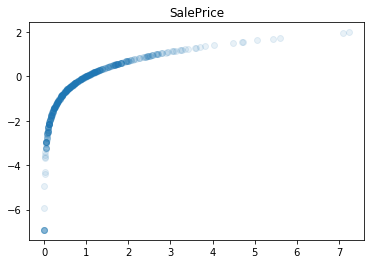

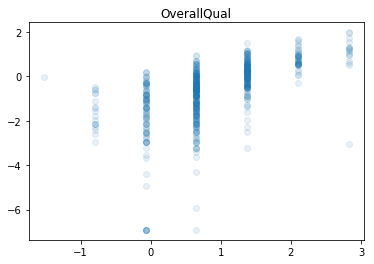

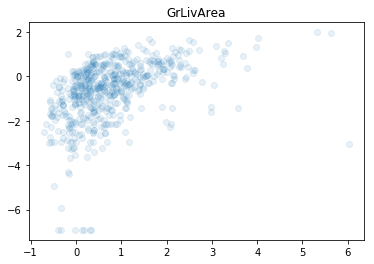

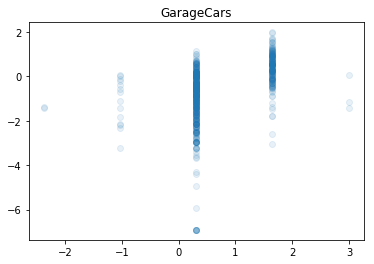

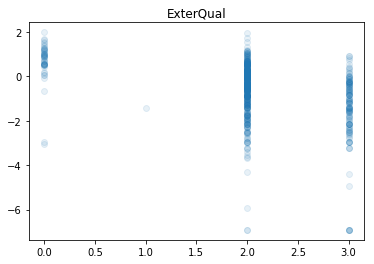

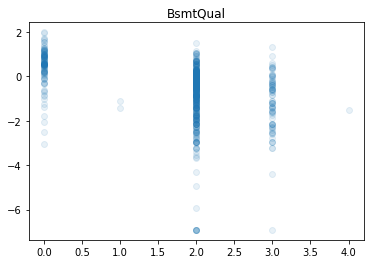

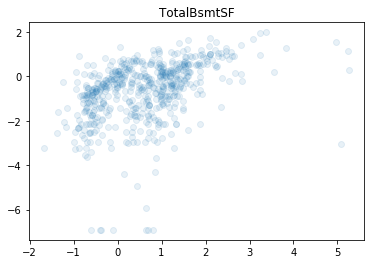

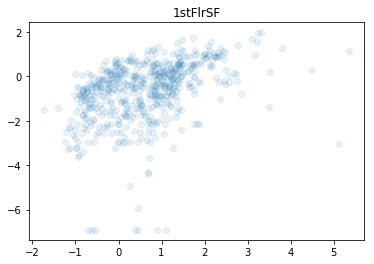

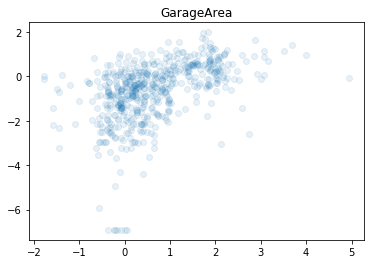

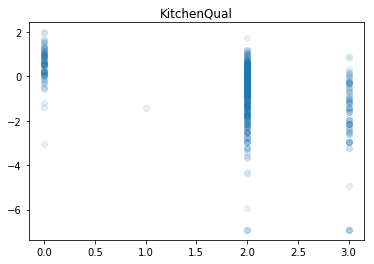

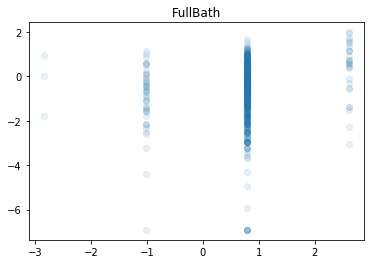

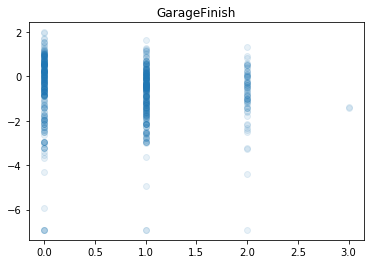

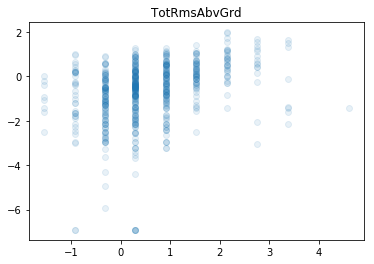

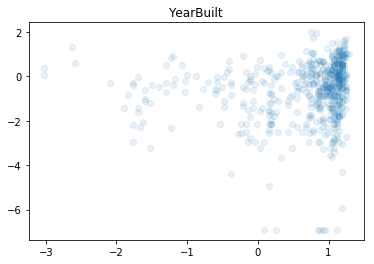

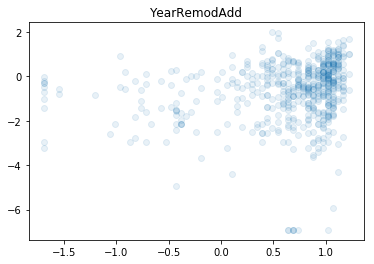

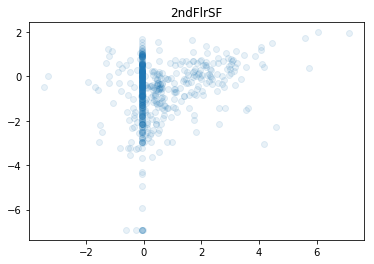

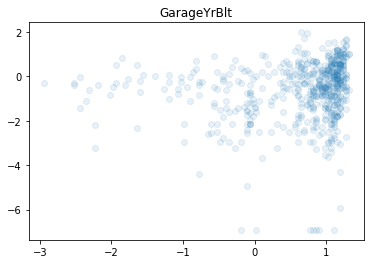

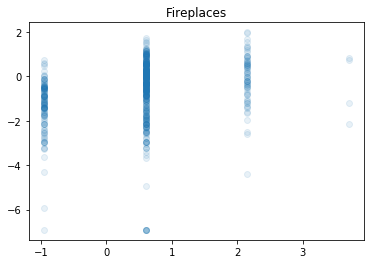

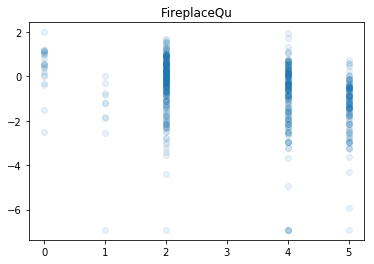

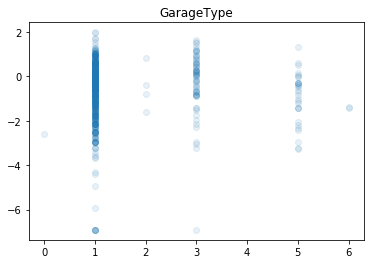

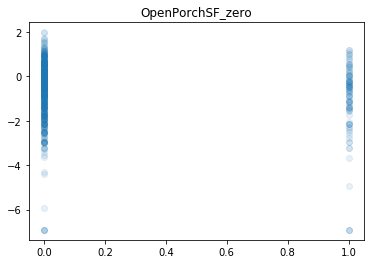

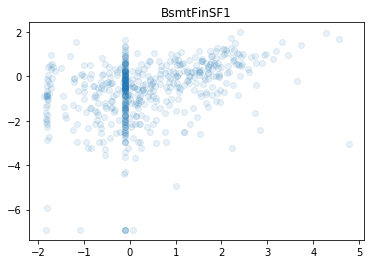

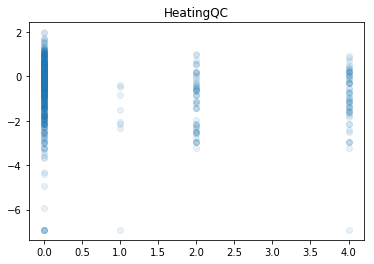

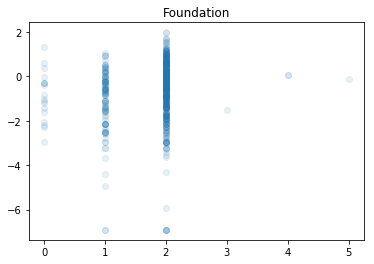

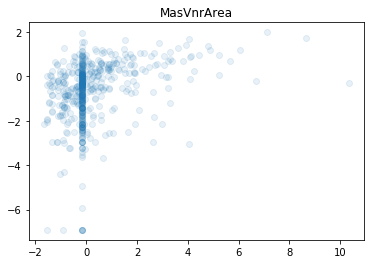

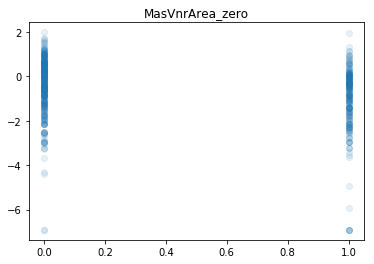

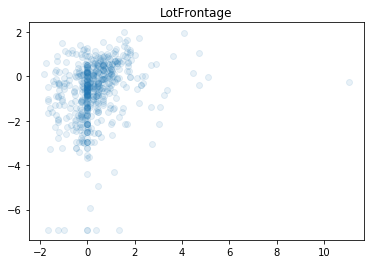

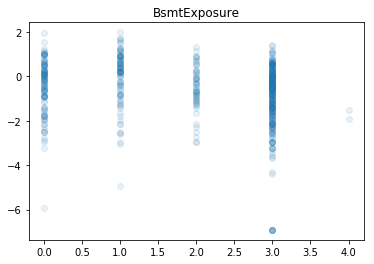

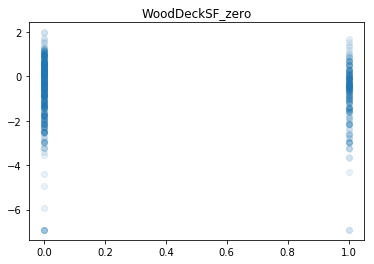

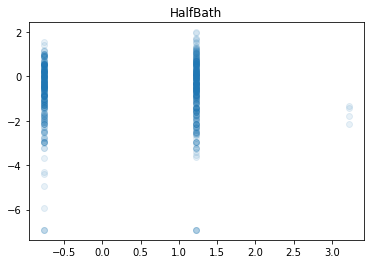

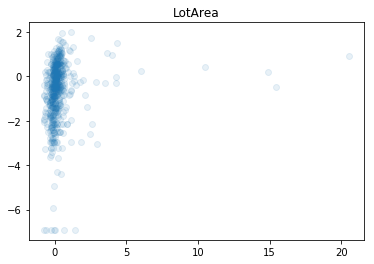

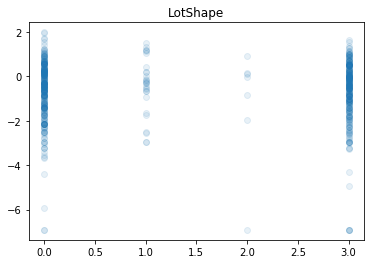

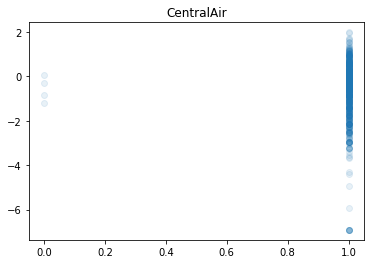

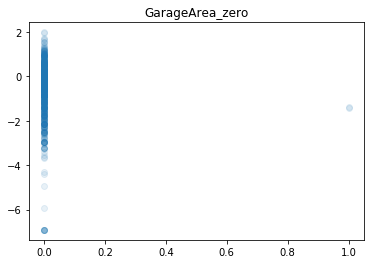

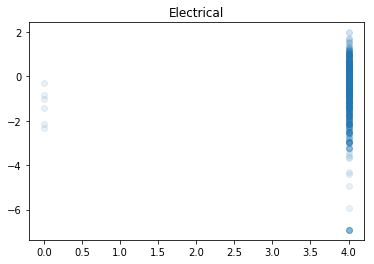

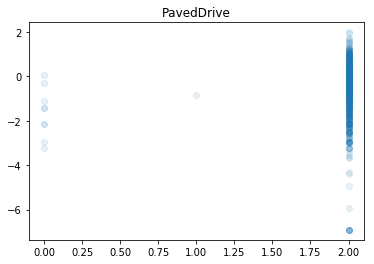

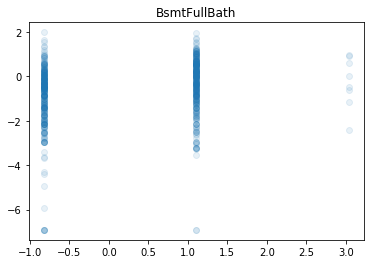

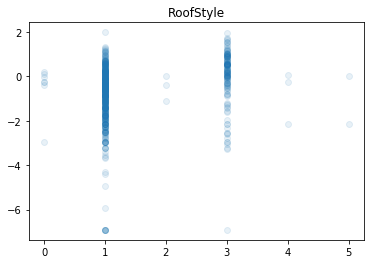

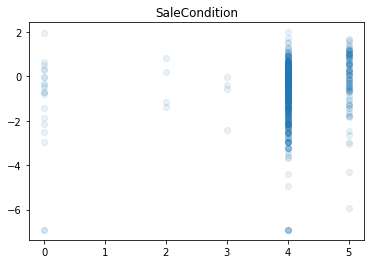

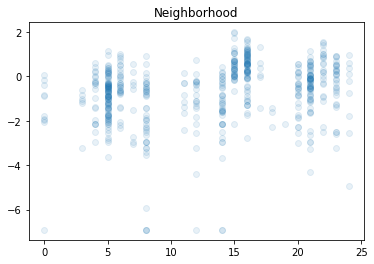

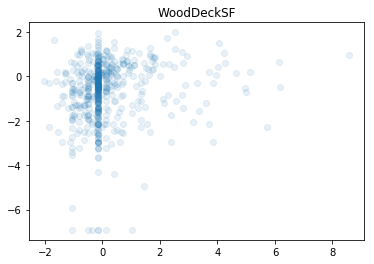

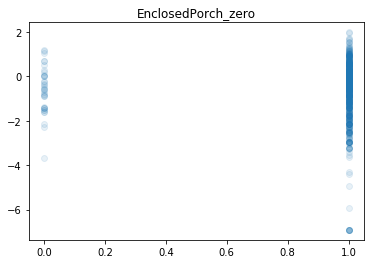

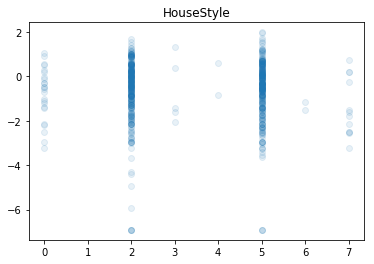

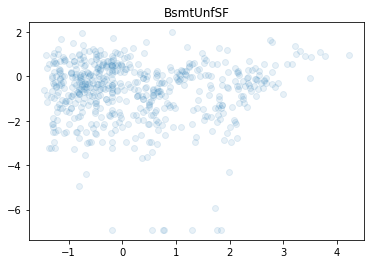

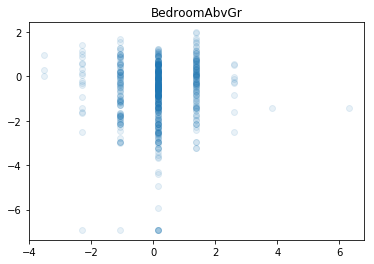

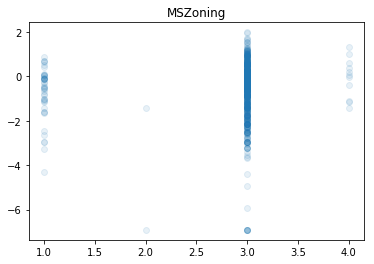

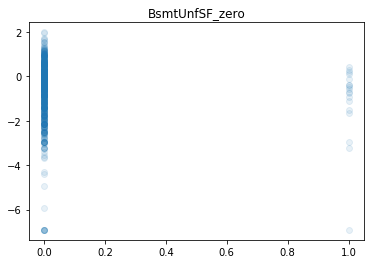

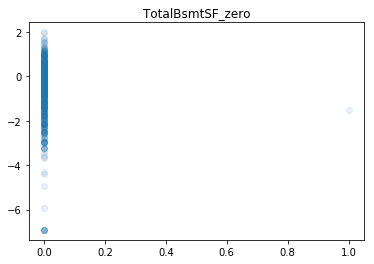

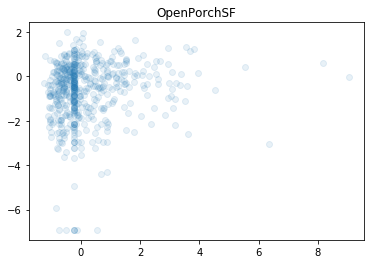

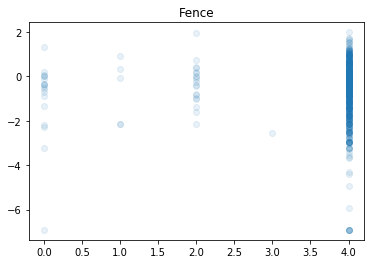

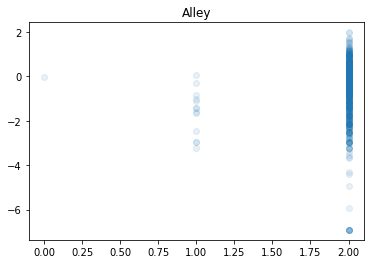

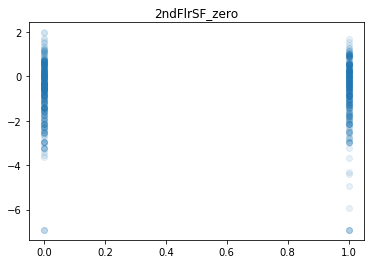

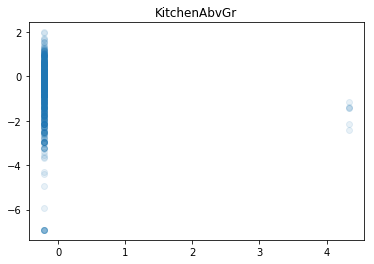

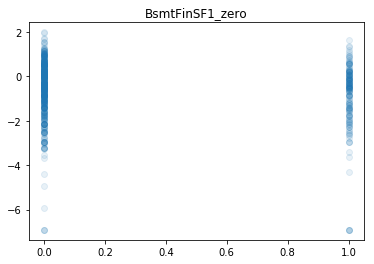

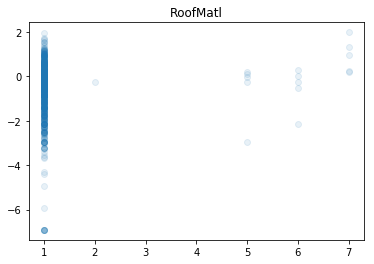

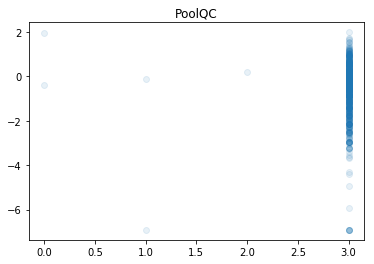

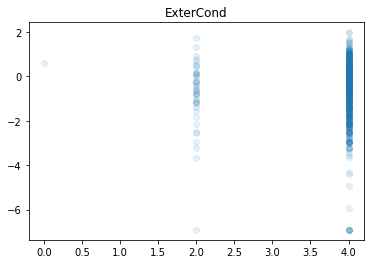

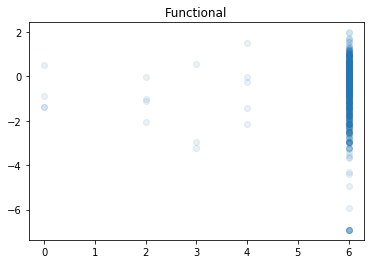

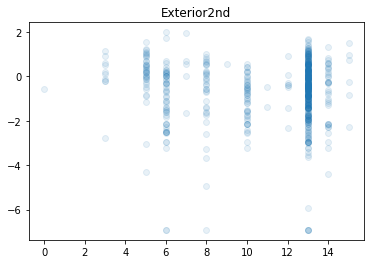

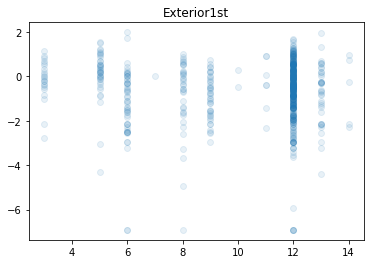

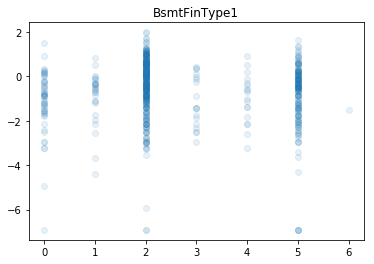

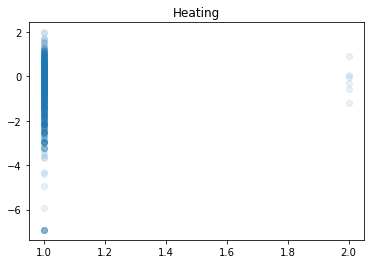

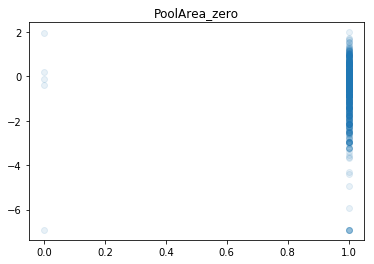

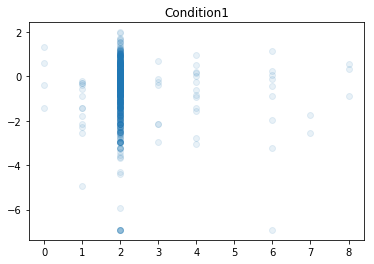

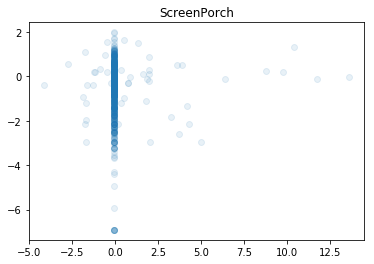

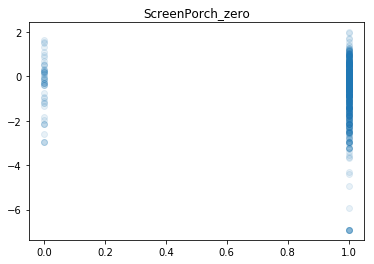

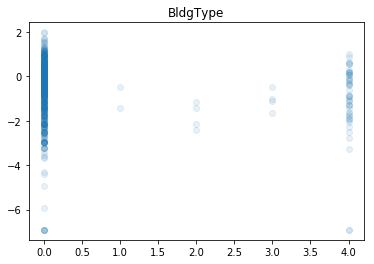

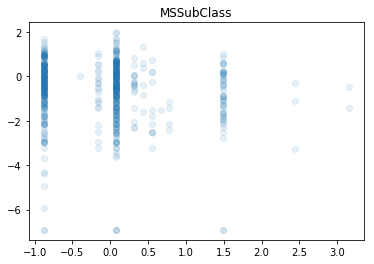

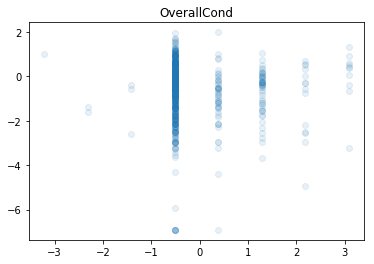

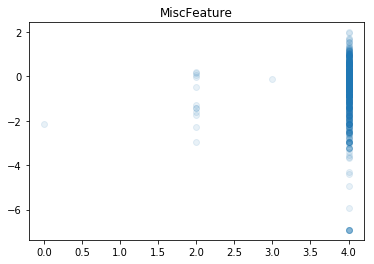

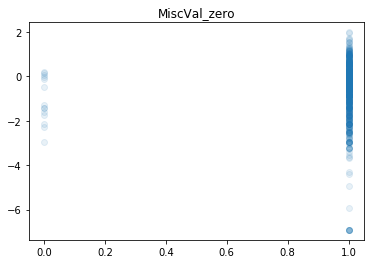

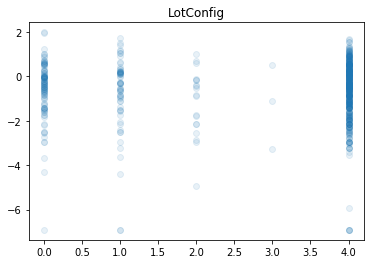

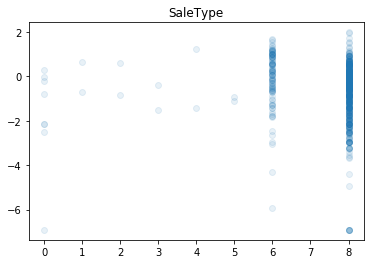

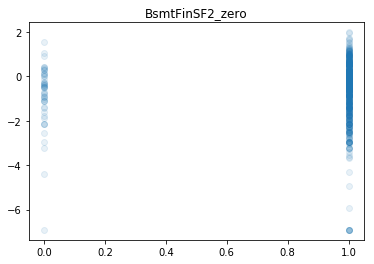

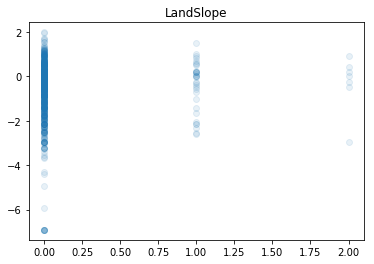

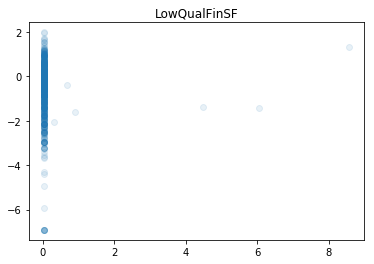

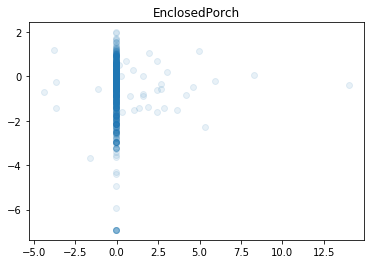

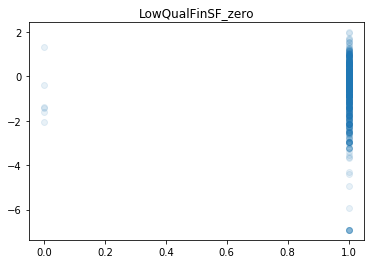

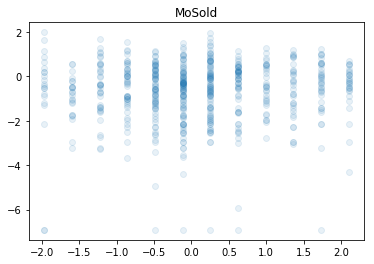

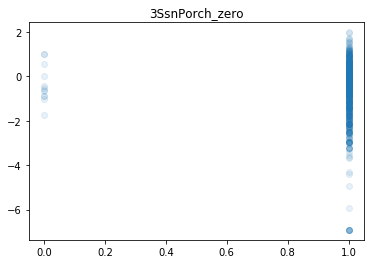

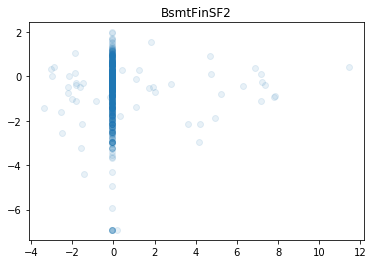

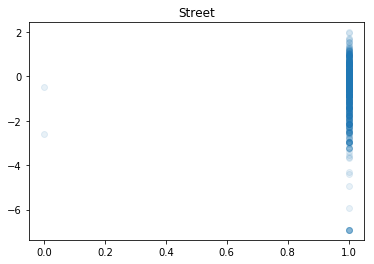

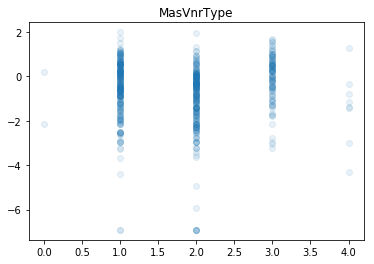

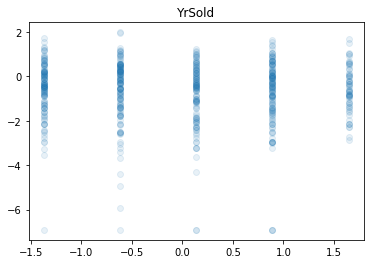

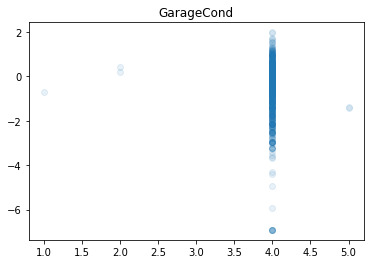

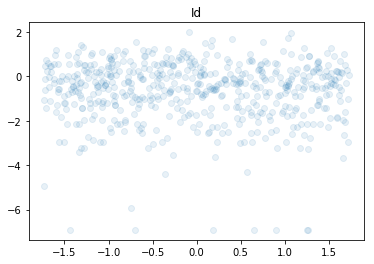

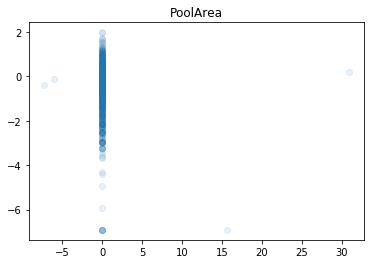

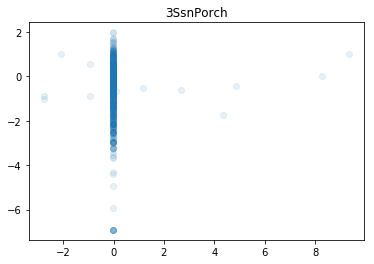

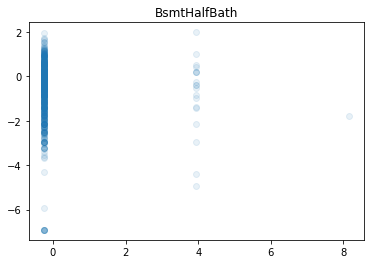

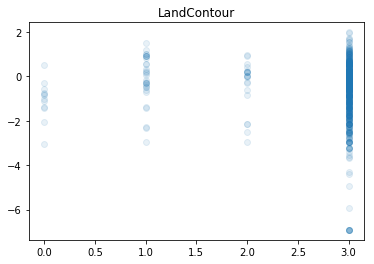

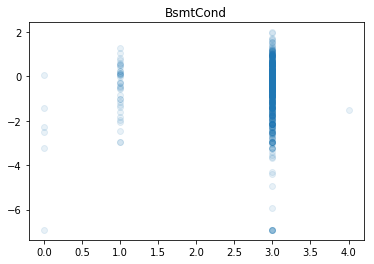

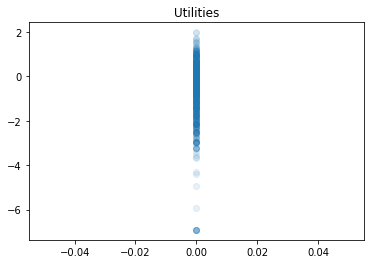

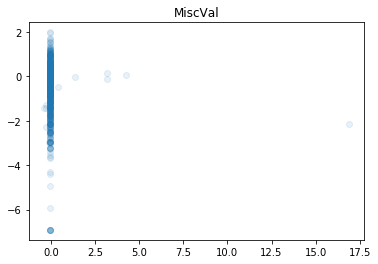

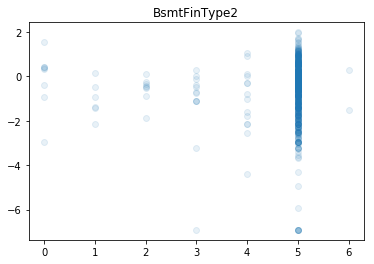

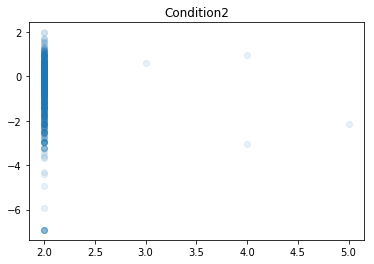

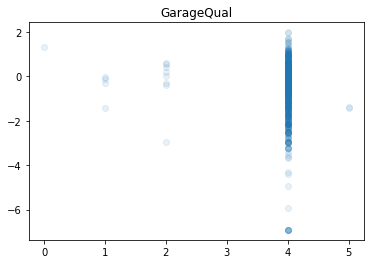

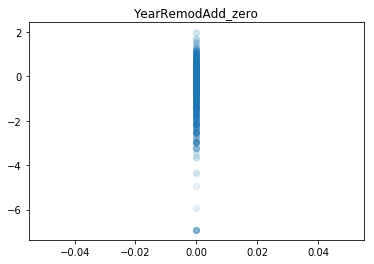

In [53]:
make_plots(data[ascending_correlation.index])

In [77]:
ascending_correlation.index

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'ExterQual',
       'BsmtQual', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', 'KitchenQual',
       'FullBath', 'GarageFinish', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
       '2ndFlrSF', 'GarageYrBlt', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'OpenPorchSF_zero', 'BsmtFinSF1', 'HeatingQC', 'Foundation',
       'MasVnrArea', 'MasVnrArea_zero', 'LotFrontage', 'BsmtExposure',
       'WoodDeckSF_zero', 'HalfBath', 'LotArea', 'LotShape', 'CentralAir',
       'GarageArea_zero', 'Electrical', 'PavedDrive', 'BsmtFullBath',
       'RoofStyle', 'SaleCondition', 'Neighborhood', 'WoodDeckSF',
       'EnclosedPorch_zero', 'HouseStyle', 'BsmtUnfSF', 'BedroomAbvGr',
       'MSZoning', 'BsmtUnfSF_zero', 'TotalBsmtSF_zero', 'OpenPorchSF',
       'Fence', 'Alley', '2ndFlrSF_zero', 'KitchenAbvGr', 'BsmtFinSF1_zero',
       'RoofMatl', 'PoolQC', 'ExterCond', 'Functional', 'Exterior2nd',
       'Exterior1st', 'BsmtFinType1', 'Heating', '

In [79]:
for i in ascending_correlation.index:
    print(i)

SalePrice
OverallQual
GrLivArea
GarageCars
ExterQual
BsmtQual
TotalBsmtSF
1stFlrSF
GarageArea
KitchenQual
FullBath
GarageFinish
TotRmsAbvGrd
YearBuilt
YearRemodAdd
2ndFlrSF
GarageYrBlt
Fireplaces
FireplaceQu
GarageType
OpenPorchSF_zero
BsmtFinSF1
HeatingQC
Foundation
MasVnrArea
MasVnrArea_zero
LotFrontage
BsmtExposure
WoodDeckSF_zero
HalfBath
LotArea
LotShape
CentralAir
GarageArea_zero
Electrical
PavedDrive
BsmtFullBath
RoofStyle
SaleCondition
Neighborhood
WoodDeckSF
EnclosedPorch_zero
HouseStyle
BsmtUnfSF
BedroomAbvGr
MSZoning
BsmtUnfSF_zero
TotalBsmtSF_zero
OpenPorchSF
Fence
Alley
2ndFlrSF_zero
KitchenAbvGr
BsmtFinSF1_zero
RoofMatl
PoolQC
ExterCond
Functional
Exterior2nd
Exterior1st
BsmtFinType1
Heating
PoolArea_zero
Condition1
ScreenPorch
ScreenPorch_zero
BldgType
MSSubClass
OverallCond
MiscFeature
MiscVal_zero
LotConfig
SaleType
BsmtFinSF2_zero
LandSlope
LowQualFinSF
EnclosedPorch
LowQualFinSF_zero
MoSold
3SsnPorch_zero
BsmtFinSF2
Street
MasVnrType
YrSold
GarageCond
Id
PoolArea
3Ss

In [51]:
#for i in data[ascending_correlation.index].columns:
#    print(i, data[i].iloc[0])

In [103]:
#from sklearn.preprocessing import OneHotEncoder
#encoder = OneHotEncoder()
#housing_cat_1hot = encoder.fit_transform(data['MSZoning', 'ExterQual'].values.reshape(-1,1))

### To do:
1. finish 1-hot
2. do 1 hot for all bad numerical data that has clustering at 0. replace 0 by median? or mean? or some nice estimator
3. 

In [82]:
df = pd.DataFrame({'A':[0,2,3]})
add_0_indicators(df)

In [83]:
df

,A,A_zero
0,2.5,1
1,2.0,0
2,3.0,0


In [66]:
test(df)

In [67]:
df

,A
0,0
1,99
2,99


In [68]:
1*(df['A'] > 0)

0    0
1    1
2    1
Name: A, dtype: int32

In [13]:
def test(l):
    l = l + [1]

In [14]:
x = [1,2,3]
test(x)
print(x)

[1, 2, 3]
